In [5]:
!pip install pandas
!pip install scikit-learn
!pip install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd

data = pd.read_csv('dataset.csv')


/var/folders/0y/351vn2xd0b1870yhsr8gwh2m0000gn/T/ipykernel_34653/590225929.py:3: DtypeWarning: Columns (0,3,5,6,7,8,9,10,11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


In [7]:
# Convert the column to datetime if it isn't already
data['track_album_release_date'] = pd.to_datetime(data['track_album_release_date'], errors='coerce')

# Convert track album to year
#data['year'] = data['track_album_release_date'].dt.year.fillna(-1).astype(int).astype(str)

# Extract just the year
data['year'] = data['track_album_release_date'].dt.year.astype('Int64')
data['year']

0        2001
1        2017
2        2005
3        2012
4        2019
         ... 
41064    <NA>
41065    <NA>
41066    <NA>
41067    <NA>
41068    <NA>
Name: year, Length: 41069, dtype: Int64

In [8]:
data = data.dropna(subset=['track_popularity'])
data.shape[0]

40721

In [9]:
from sklearn.model_selection import train_test_split # splits training from real data 
from sklearn.pipeline import Pipeline
# applies transformations to diff sub # chains processing sets
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from  sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor  # You can swap with any regressor
from sklearn.metrics import mean_squared_error


data['lyrics'] = data['lyrics'].fillna('')
# we will use these variables will predict track_popularity
numerical_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_features = 'year'
text_feature = 'lyrics'
target = 'track_popularity'
encode_artist = 'track_artist'

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")


Test MSE: 356.21


In [10]:
# Impute missing values: use KNN or similar imputation so there are no nan values
# The MSE will be higher using KNN imputer as its not meant to improve the performance
# It uses similar (nearby) rows to guess a good value instead of using nan, cleaning up the data
from sklearn.impute import KNNImputer

numerical_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),   # You can adjust n_neighbors
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

Test MSE: 356.49


In [11]:
# adding more predictor variables, using standard scaler
data['lyrics'] = data['lyrics'].fillna('')
# we will use these variables will predict track_popularity
data['song_length_minutes'] = data['duration_ms'] / 60000
data['has_lyrics'] = data['lyrics'].apply(lambda x: 0 if x.strip() == '' else 1)
current_year = 2025
data['track_age'] = current_year - data['year'].fillna(current_year).astype(int)
data['lyrics_length'] = data['lyrics'].apply(lambda x: len(x.split()))

def bucket_tempo(t):
    if t < 90:
        return 0
    elif t < 140:
        return 1
    else:
        return 2

data['tempo_bucket'] = data['tempo'].apply(bucket_tempo)

numerical_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 
                      'duration_ms', 'song_length_minutes', 'has_lyrics', 
                      'track_age', 'lyrics_length', 'tempo_bucket']
categorical_features = 'year'
text_feature = 'lyrics'
target = 'track_popularity'
encode_artist = 'track_artist'

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

Test MSE: 347.17


/var/folders/0y/351vn2xd0b1870yhsr8gwh2m0000gn/T/ipykernel_37441/2939237185.py:15: DtypeWarning: Columns (0,3,5,6,7,8,9,10,11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


📉 MSE : 443.72
📈 R²  : 0.018


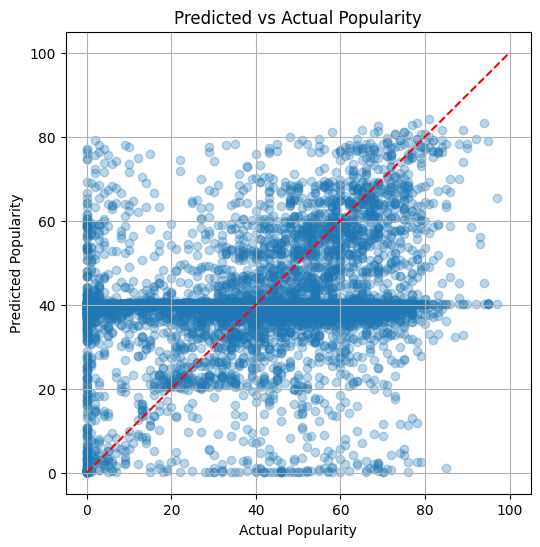

In [2]:
# --- FAST RANDOM FOREST WITHOUT GRID SEARCH ---------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# 1) LOAD DATA ---------------------------------------------------
data = pd.read_csv('dataset.csv')
data = data.dropna(subset=['track_popularity'])
data['lyrics'] = data['lyrics'].fillna('')

# Handle year
if 'track_album_release_date' in data.columns:
    data['track_album_release_date'] = pd.to_datetime(data['track_album_release_date'], errors='coerce')
    data['year'] = data['track_album_release_date'].dt.year

# 2) FEATURES ----------------------------------------------------
data['song_length_minutes'] = data['duration_ms'] / 60000
data['has_lyrics'] = data['lyrics'].str.strip().ne('').astype(int)
data['track_age'] = 2025 - data['year'].fillna(2025)
data['lyrics_length'] = data['lyrics'].str.split().apply(len)
data['tempo_bucket'] = data['tempo'].apply(lambda t: 0 if t < 90 else 1 if t < 140 else 2)

numeric_features = [
    'danceability','energy','speechiness','acousticness','instrumentalness',
    'liveness','valence','tempo','duration_ms','song_length_minutes',
    'track_age','lyrics_length'
]
numeric_features = [f for f in numeric_features if f in data.columns]

categorical_features = [
    'year','mode','playlist_genre','playlist_subgenre','tempo_bucket','key','has_lyrics'
]
categorical_features = [f for f in categorical_features if f in data.columns]

text_feature = 'lyrics'
artist_feature = 'track_artist'
target = 'track_popularity'

X = data[numeric_features + categorical_features + [text_feature, artist_feature]]
y = data[target]

# 3) PIPELINE ----------------------------------------------------
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('text', text_pipeline, text_feature),
    ('artist', TargetEncoder(handle_unknown='value', handle_missing='value'), [artist_feature])
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=150, max_depth=10, min_samples_leaf=1, random_state=42))
])

# 4) TRAIN + EVAL -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_small = X_train.sample(min(5000, len(X_train)), random_state=42)
y_train_small = y_train.loc[X_train_small.index]

model.fit(X_train_small, y_train_small)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("📉 MSE :", round(mse, 2))
print("📈 R²  :", round(r2, 3))

# 5) PLOT --------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,100], [0,100], 'r--')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs Actual Popularity')
plt.grid(True)
plt.show()
